In [1]:
# import data from csv files
!pip install gdown
!gdown "https://drive.google.com/uc?id=1isIiMdaS97UOmX1pDppI1EdNyL7Nu2MT"
!gdown "https://drive.google.com/uc?id=1xbSC8V8PsKfmlvELjlOy2moGt4Cf2s0P"

f_train = 'train.csv'
f_test = 'test_nolabels.csv'

Downloading...
From: https://drive.google.com/uc?id=1isIiMdaS97UOmX1pDppI1EdNyL7Nu2MT
To: /content/test_nolabels.csv
100% 4.82M/4.82M [00:00<00:00, 15.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xbSC8V8PsKfmlvELjlOy2moGt4Cf2s0P
To: /content/train.csv
100% 252M/252M [00:06<00:00, 39.9MB/s]


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
import sklearn
import random
import torch
from typing import Tuple, Callable, List, NamedTuple
import torchvision
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
print(f"Your version of Pytorch is {torch.__version__}. You should use a version >0.4.")

# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

Your version of Pytorch is 1.10.0+cu111. You should use a version >0.4.
cpu


In [3]:
# preprocess data
train_data = pd.read_csv(f_train)
test_data = pd.read_csv(f_test)

X = train_data.iloc[:, 1:-1].to_numpy().astype(np.float)
print(X.shape)  # original features
y = train_data.iloc[:, -1].to_numpy().astype(np.float)
print(y.shape)  # binary label

test_X = test_data.iloc[:, 1:].to_numpy().astype(np.float)
print(test_X.shape)

(62000, 216)
(62000,)
(1200, 216)


In [4]:
def normalize(train_X, valid_X):
  train_mean = np.mean(train_X, axis=0)
  train_std = np.std(train_X, axis=0)

  train_X_new = (train_X- train_mean)/train_std
  valid_X_new = (valid_X- train_mean)/train_std
  return train_X_new, valid_X_new

In [5]:
#@title f1 score def
def f1_score(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. 0 <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    
    '''
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1

### **Random Forest**

In [8]:
#@title RF trialing
n_estimators = 100
max_depths = list(range(10,100,5))
kf = KFold(n_splits=10, shuffle=True)
kf_f1 = []
kf_acc = []

cv_f1 = []
for train, valid in kf.split(X):
    f1_vals = []
    f1_trs = []
    X_train_n, X_valid_n = normalize(X[train], X[valid])
    for max_depth in max_depths:
        print('Current max_dept >>> ', max_depth)
        model = RandomForestClassifier(n_estimators=n_estimators,
                                      max_depth=max_depth)
        model.fit(X_train_n, y[train])
        preds = model.predict(X_valid_n)
        preds_tr = model.predict(X_train_n)

        f1_val = sklearn.metrics.f1_score(y[valid], preds)
        f1_tr = sklearn.metrics.f1_score(y[train], preds_tr)
        print('F1 for RF (train, valid)', f1_tr, f1_val)
        f1_vals.append(f1_val)
        f1_trs.append(f1_tr)
    break

Current max_dept >>>  10
F1 for RF (train, valid) 0.9120087838010367 0.871889400921659
Current max_dept >>>  15
F1 for RF (train, valid) 0.9678241896900712 0.8835736897643335
Current max_dept >>>  20
F1 for RF (train, valid) 0.9875620891405925 0.8834951456310679
Current max_dept >>>  25
F1 for RF (train, valid) 0.9923448452151917 0.8817868599263395
Current max_dept >>>  30
F1 for RF (train, valid) 0.9937623775715035 0.8857786739414067
Current max_dept >>>  35
F1 for RF (train, valid) 0.9942171598031946 0.8823738872403561
Current max_dept >>>  40
F1 for RF (train, valid) 0.9943103680733452 0.8868283404660009
Current max_dept >>>  45
F1 for RF (train, valid) 0.9943379438647577 0.8853238265002971
Current max_dept >>>  50
F1 for RF (train, valid) 0.9943390122924304 0.8829749316858738
Current max_dept >>>  55
F1 for RF (train, valid) 0.9943374858437145 0.8811387900355871
Current max_dept >>>  60
F1 for RF (train, valid) 0.9943391648920399 0.88158050396309
Current max_dept >>>  65
F1 for RF 

[None]

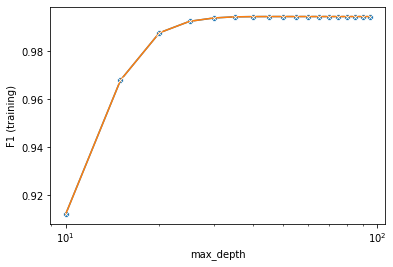

In [9]:
# Plot for Random forest max depth
########################
df = pd.DataFrame()
df['max_depth'] = max_depths
df['F1 (validation)'] = f1_vals
df['F1 (training)'] = f1_trs
ax = sns.lineplot(
      data=df,
      x="max_depth", y="F1 (training)",
      marker='o'
      )
ax = sns.lineplot(
    data=df,
    x="max_depth", y="F1 (training)",
    marker='x'
)
ax.set(xscale='log')

### **AdaBoost**

In [ ]:
#@title AdaBoost trialing
n_estimators = 100 
kf = KFold(n_splits=10, shuffle=True)
kf_f1 = []
kf_acc = []

cv_f1 = []
for train, valid in kf.split(X):
    f1_vals = []
    f1_trs = []
    X_train_n, X_valid_n = Trainer.normalize(X[train], X[valid])
    for max_depth in max_depths:
        model = AdaBoostClassifier(n_estimators=n_estimators)
        model.fit(X_train_n, y[train])
        preds = model.predict(X_valid_n)
        preds_tr = model.predict(X_train_n)
        f1_val = sklearn.metrics.f1_score(y[valid], preds)
        f1_tr = sklearn.metrics.f1_score(y[train], preds_tr)
        print('F1 for AdaBoost (train, valid)', f1_tr, f1_val)
        f1_vals.append(f1_val)
        f1_trs.append(f1_tr)
        break
    # cv_f1.append(np.mean(moving_f1))
    break

F1 for AdaBoost (train, valid) 0.8483495951837243 0.837516201248969


### **XGBoost**

In [ ]:
#@title XGBoost data
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
#!pip sklearn
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn import metrics   #Additional     scklearn functions
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

standardization(X)
data = standardization(X) 
label = y 

train_x, test_x, train_y, test_y = train_test_split(data, label, random_state=0)
dtrain=xgb.DMatrix(train_x,label=train_y)
dtest=xgb.DMatrix(test_x)

In [ ]:
#@title XGBoost params
params = {'booster':'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'gamma':0.1,
    'max_depth':18,
    'lambda':5,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.05,
    'seed':0,
    'nthread':8,}

CV score: 0.8847883999999999


<Figure size 432x288 with 0 Axes>

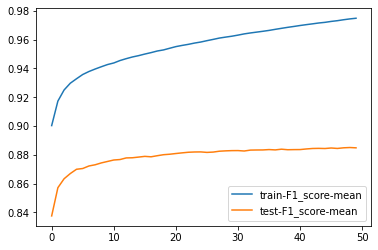

In [ ]:
#@title XGBoost trialing
def f1_eval(predt, dtrain):
    y = dtrain.get_label()
    predt_binary = np.where(predt > 0.5, 1, 0)
    return "F1_score", sklearn.metrics.f1_score(y_true=y, y_pred=predt_binary)

bst_cv1 = xgb.cv(params, dtrain, num_boost_round=50, nfold=5, 
                feval=f1_eval, maximize=False)

print ('CV score:', bst_cv1.iloc[-1,:]['test-F1_score-mean']) 
plt.figure() 
bst_cv1[['train-F1_score-mean', 'test-F1_score-mean']].plot()